In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, HistGradientBoostingClassifier,  VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)


In [4]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

Train data: (165034, 13)
Test data: (110023, 12)



In [5]:
def new_features(df):
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x > 65 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['AvgBalancePerProduct'] = df['Balance'] / df['NumOfProducts']
    df['TenureToAgeRatio'] = df['Tenure'] / df['Age']
    df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
    df['Geo_Gender'] = df['Geography'] + "_" + df['Gender']
    df['CreditScoreTier'] = pd.cut(df['CreditScore'], bins=[0, 650, 750, 850], labels=['Low', 'Medium', 'High'])
    
    return df

train_df = new_features(train)
test_df = new_features(test)

In [6]:
vectorizer = TfidfVectorizer(max_features=1000)
vectors_train = vectorizer.fit_transform(train_df['Surname'])
vectors_test = vectorizer.transform(test_df['Surname'])
#
svd = TruncatedSVD(3)
x_pca_train = svd.fit_transform(vectors_train)
x_pca_test = svd.transform(vectors_test)

# Convert to DataFrames
tfidf_df_train = pd.DataFrame(x_pca_train)
tfidf_df_test = pd.DataFrame(x_pca_test)

# Naming columns in the new DataFrames
cols = [('Surname' + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
tfidf_df_train.columns = cols
tfidf_df_test.columns = cols
    
# Reset the index of the DataFrames before concatenation
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Concatenate transformed features with original data
train_df = pd.concat([train_df, tfidf_df_train], axis="columns")
test_df = pd.concat([test_df, tfidf_df_test], axis="columns")

In [7]:
to_drop = ['CustomerId', 'Surname']
train = train_df.drop(to_drop, axis=1)
test = test_df.drop(to_drop, axis=1)


In [8]:
train = train.drop_duplicates()

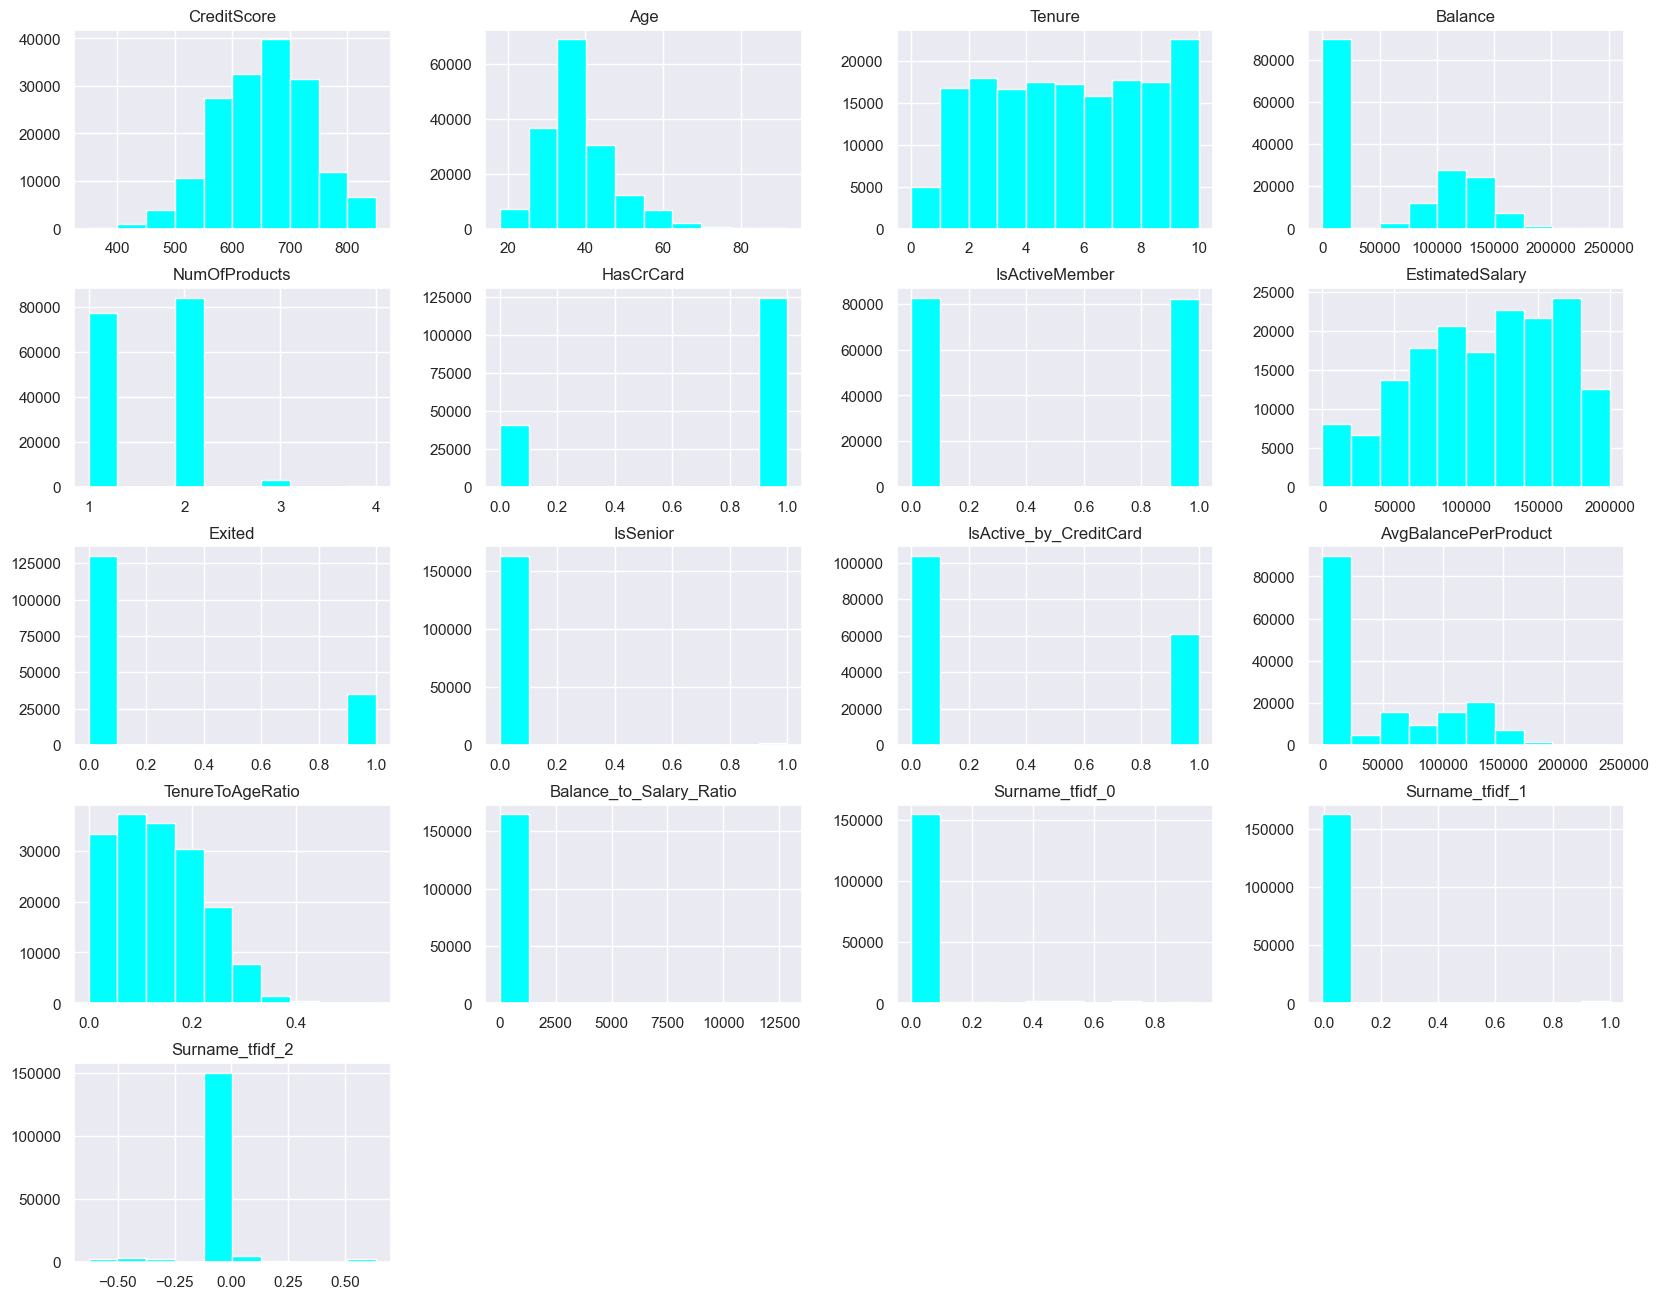

In [9]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='aqua');

In [10]:
columns_to_encode = ['Geo_Gender', 'CreditScoreTier']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
col_encoded = pd.DataFrame(encoder.fit_transform(train[columns_to_encode]), columns=encoder.get_feature_names_out(columns_to_encode), index=train.index)
col_encoded_test = pd.DataFrame(encoder.transform(test[columns_to_encode]), columns=encoder.get_feature_names_out(columns_to_encode), index=test.index)

In [11]:
train = pd.concat([train.drop(columns=columns_to_encode), col_encoded], axis=1)
test = pd.concat([test.drop(columns=columns_to_encode), col_encoded_test], axis=1)

In [12]:
train = train.drop(['Geography', 'Gender'], axis=1)
test = test.drop(['Geography', 'Gender'], axis=1)

In [13]:
X = train.drop(['Exited'], axis=1)
y = train['Exited']

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

for column in test.columns.tolist():
    test[column] = test[column].apply(lambda x: np.log(x + 1))

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=666, stratify=y)

In [15]:
smote = SMOTE(random_state=666)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [16]:
numeric_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'AvgBalancePerProduct']

scaler = MinMaxScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])

X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])

# Model Building and Evaluation

In [17]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state=666)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=666)

In [18]:
y_valid_preds = rf_model.predict_proba(X_valid)[:,1]

In [19]:
roc_auc_score(y_valid, y_valid_preds)

0.877092627219898

In [20]:
def train_and_evaluate_models(X_train, y_train, X_valid, y_valid):
    results_list = []

    classifiers = [
        ('LightGBM', LGBMClassifier(random_state=42, verbose=100)),
        ('XGBoost', XGBClassifier(random_state=42, verbose=100)),
        ('CatBoost', CatBoostClassifier(random_state=42, verbose=100, n_estimators=1000))
    ]

    for name, clf in classifiers:
        print(f'Training {name} model')
        clf.fit(X_train, y_train)
        y_pred_prob = clf.predict_proba(X_valid)[:, 1]
        auc_roc = roc_auc_score(y_valid, y_pred_prob)
        
        results_list.append({'Model': name, 'AUC-ROC Score': auc_roc})
    results_df = pd.DataFrame(results_list)
    return results_df

In [21]:
results_df = train_and_evaluate_models(X_train_resampled, y_train_resampled, X_valid, y_valid)

Training LightGBM model
[LightGBM] [Info] Number of positive: 104047, number of negative: 104047
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.831348
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.469268
[LightGBM] [Debug] init for col-wise cost 0.007207 seconds, init for row-wise cost 0.020296 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 4682
[LightGBM] [Info] Number of data points in the train set: 208094, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Training CatBoost model
Learning rate set to 0.100654
0:	learn: 0.6273632	total: 113ms	remaining: 1m 53s
100:	learn: 0.2544515	total: 1.64s	remaining: 14.6s
200:	learn: 0.2241103	total: 3.13s	remaining: 12.5s
300:	learn: 0.2148482	total: 4.53s	remaining: 10.5s
400:	learn: 0.2095214	total: 5.98s	remaining: 8.93s
500:	learn: 0.2056541	total: 7.41s	remaining: 7.38s
600:	learn: 0.2017747	total: 8.8s	remaining: 5.84s
700:	learn: 0.1984641	total: 10.3s	remaining: 4.37s
800:	learn: 0.1951272	total: 11.7s	remaining: 2.91s
900:	learn: 0.1922966	total: 13.1s	remaining: 1.44s
999:	learn: 0.1896065	total: 14.5s	remaining: 0us


In [22]:
results_df

,Model,AUC-ROC Score
0,LightGBM,0.892773
1,XGBoost,0.892067
2,CatBoost,0.895577


# Training model over entire trianing set and evaluating on entire test set

In [23]:
smote = SMOTE(random_state=666)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

In [24]:
scaler = MinMaxScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

In [25]:
lgbParams = {'n_estimators': 5000,
 'max_depth': 23,
 'learning_rate': 0.02,
 'min_child_weight': 1.4,
 'min_child_samples': 188,
 'subsample': 0.72,
 'subsample_freq': 2,
 'colsample_bytree': 0.42,
 'random_state': 42,
 'num_leaves': 19}

In [26]:
lgbm = LGBMClassifier(**lgbParams)
lgbm.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 130059, number of negative: 130059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4393
[LightGBM] [Info] Number of data points in the train set: 260118, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(colsample_bytree=0.42, learning_rate=0.02, max_depth=23,
               min_child_samples=188, min_child_weight=1.4, n_estimators=5000,
               num_leaves=19, random_state=42, subsample=0.72,
               subsample_freq=2)

In [27]:
y_preds = lgbm.predict_proba(test)[:, 1]

In [28]:
y_preds.shape

(110023,)

In [29]:
submission_df = pd.read_csv("sample_submission.csv")
submission_df['Exited'] = y_preds
submission_df

,id,Exited
0,165034,0.030796
1,165035,0.774482
2,165036,0.035759
3,165037,0.286136
4,165038,0.303086
...,...,...
110018,275052,0.023421
110019,275053,0.221939
110020,275054,0.011451
110021,275055,0.185582


In [30]:
submission_df.to_csv('submission.csv', index=False)